In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib
%matplotlib inline
from netCDF4 import Dataset


import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.colors as colors
from sklearn import datasets
import iris.analysis
import numpy.ma as ma

import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point


from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

import matplotlib.cm as mpl_cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.pyplot import xcorr


from scipy.interpolate import splrep, splev
from scipy.stats import pearsonr
from scipy import signal 

import math
from matplotlib import mlab

import warnings
warnings.filterwarnings("ignore")

In [3]:
cube_ccsm_amoc = iris.load_cube('CCSM4_midHolocene.cvdp_data.1000-1300.nc', 'amoc_timeseries_ann')

# CESM model: ValueError: Missing data dimensions for multi-valued DimCoord 'time'
#cube_cesm_amoc = iris.load_cube('CESM2_midHolocene.cvdp_data.1-700.nc', 'amoc_timeseries_ann')

cube_ec_amoc = iris.load_cube('EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'amoc_timeseries_ann')

cube_fgoalsg2_amoc = iris.load_cube('FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', 'amoc_timeseries_ann')

cube_giss_amoc = iris.load_cube('GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'amoc_timeseries_ann')

cube_hadgem_amoc = iris.load_cube('HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'amoc_timeseries_ann')

cube_inm_amoc = iris.load_cube('INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'amoc_timeseries_ann')

cube_ipsl_amoc = iris.load_cube('IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'amoc_timeseries_ann')

cube_mpi2_amoc = iris.load_cube('MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'amoc_timeseries_ann')

cube_mri_amoc = iris.load_cube('MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'amoc_timeseries_ann')

cube_mpip_amoc = iris.load_cube('MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', 'amoc_timeseries_ann')

cube_mri3_amoc = iris.load_cube('MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc', 'amoc_timeseries_ann')

cube_noresm2_amoc = iris.load_cube('NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'amoc_timeseries_ann')



In [4]:

cube_ccsm_amo = iris.load_cube('CCSM4_midHolocene.cvdp_data.1000-1300.nc', 'amo_timeseries_mon')

# CESM model: ValueError: Missing data dimensions for multi-valued DimCoord 'time'
#cube_cesm_amo = iris.load_cube('CESM2_midHolocene.cvdp_data.1-700.nc', 'amo_timeseries_mon')

cube_ec_amo = iris.load_cube('EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'amo_timeseries_mon')

cube_fgoalsg2_amo = iris.load_cube('FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', 'amo_timeseries_mon')

cube_giss_amo = iris.load_cube('GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'amo_timeseries_mon')

cube_hadgem_amo = iris.load_cube('HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'amo_timeseries_mon')

cube_inm_amo = iris.load_cube('INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'amo_timeseries_mon')

cube_ipsl_amo = iris.load_cube('IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'amo_timeseries_mon')

cube_mpi2_amo = iris.load_cube('MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'amo_timeseries_mon')

cube_mri_amo = iris.load_cube('MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'amo_timeseries_mon')

cube_mpip_amo = iris.load_cube('MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', 'amo_timeseries_mon')

cube_mri3_amo = iris.load_cube('MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc', 'amo_timeseries_mon')

cube_noresm2_amo = iris.load_cube('NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'amo_timeseries_mon')



## apply the low pass Lanczos filter to AMOC and AMO / NAO timeseries in mh

In [5]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window. (window_length must be a positive odd integer.)

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


In [6]:
for coord in cube_ccsm_amoc.coords():
    print(coord.name())
 

time


In [8]:
#no CESM model which has 'time' coord problems, can't load the file with iris cube

cube_modelname=['ccsm', 'ec', 'fgoalsg2', 'giss',
          'hadgem', 'inm', 'ipsl', 'mpi2', 'mri',
          'mpip', 'mri3', 'noresm2']

In [9]:
cube_model_name=['CCSM4','EC_Earth3-LR','FGOALS-G2','GISS-E2-1-G','HadGEM3-CG31-LL',
           'INM-CM4-8','IPSL-CM6A-LR','MPI-ESM1-2-LR','MRI-ESM2-0','MPI-ESM-P','MRI-CGCM3',
           'NorESM2-LM']

In [10]:
cube_legend_color=['orangered','yellow','limegreen','deepskyblue','slategrey','darkorchid',
            'chocolate','darkgreen','turquoise','violet','blue','pink']

In [11]:
cube_amoc_ann=[cube_ccsm_amoc,  cube_ec_amoc, 
                cube_fgoalsg2_amoc, cube_giss_amoc, cube_hadgem_amoc, 
                cube_inm_amoc, cube_ipsl_amoc, cube_mpi2_amoc, 
                cube_mri_amoc, cube_mpip_amoc, cube_mri3_amoc, 
                cube_noresm2_amoc]


In [12]:
cube_amo_mon=[cube_ccsm_amo, cube_ec_amo, 
                cube_fgoalsg2_amo, cube_giss_amo, cube_hadgem_amo, 
                cube_inm_amo, cube_ipsl_amo, cube_mpi2_amo, 
                cube_mri_amo, cube_mpip_amo, cube_mri3_amo, 
                cube_noresm2_amo]



In [63]:
window = 51  #(50+1)

# construct 15-year low pass filters
# for the AMOC data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'_amoc_fil'] = cube_amoc_ann[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)

    

In [68]:
print(globals()[cube_modelname[0]+'_amoc_fil'].data.shape) #CCSM model has 251 years data remains 

(251,)


In [64]:
print(globals()[cube_modelname[3]+'_amoc_fil'].data.shape) #GISS model has 50 years data remains 

(50,)


In [65]:
window = 601  #(50*12+1)

# construct 15-year (180-month)  low pass filters
# for the AMO data which is monthly
wgts180 = low_pass_weights(window, 1. / 180.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'_amo_fil'] = cube_amo_mon[j].rolling_window('time',iris.analysis.MEAN,len(wgts180),weights=wgts180)
    

In [66]:
print(globals()[cube_modelname[3]+'_amo_fil'].data.shape)

(600,)


## plotting: AMOC and AMO cross-correlation (annual) in simulations in MH

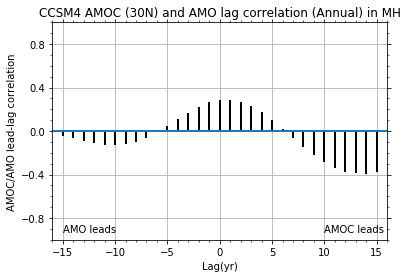

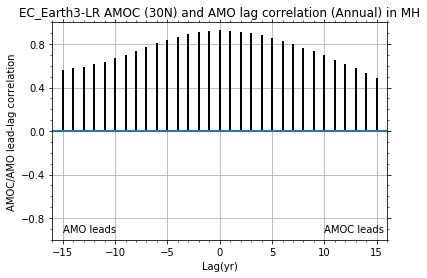

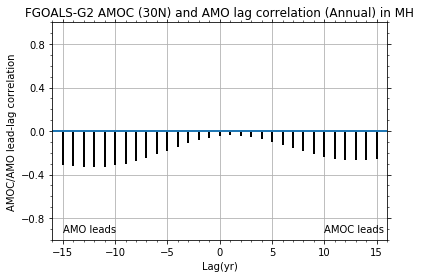

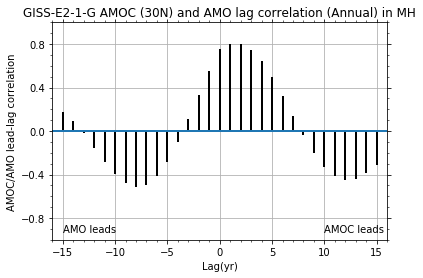

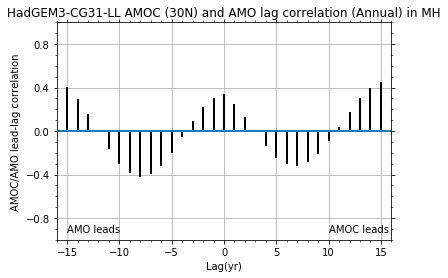

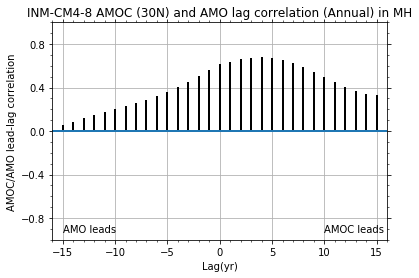

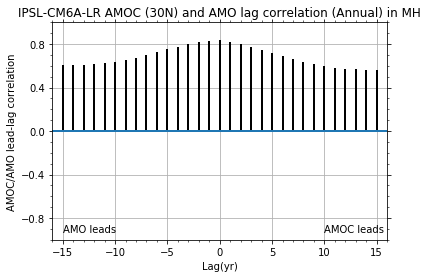

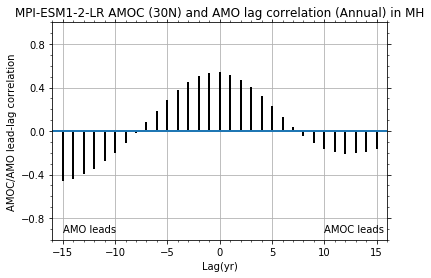

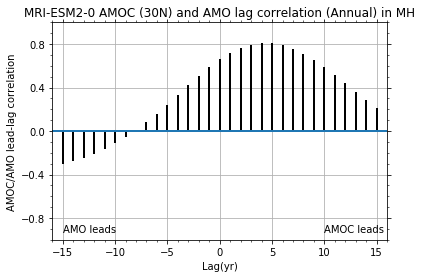

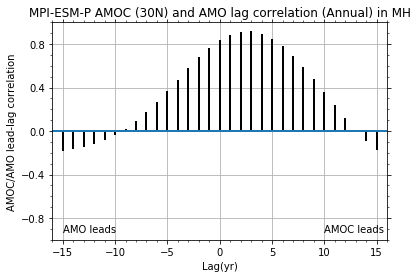

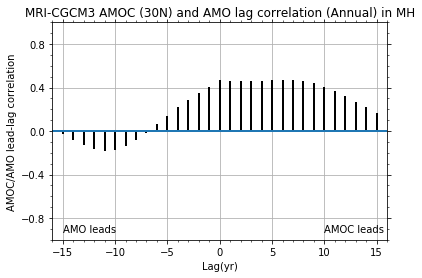

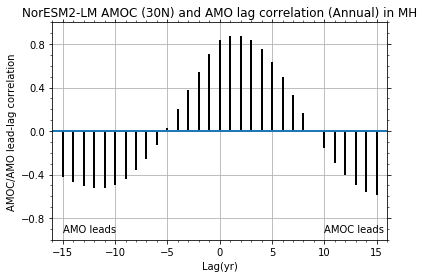

In [67]:
for j in range (0,len(cube_modelname)):
    month=globals()[cube_modelname[j]+'_amo_fil'].data.shape
    timestep=np.arange(0,month[0],12)
    amo_ann=[]
    for i in timestep:
        amo_ann.append((globals()[cube_modelname[j]+'_amo_fil'].data[i:i+12].sum())/12)

    fig=plt.figure()
    ax=fig.add_subplot(111)


    ax.xcorr(amo_ann, globals()[cube_modelname[j]+'_amoc_fil'].data, detrend=mlab.detrend, usevlines=True, maxlags=15, normed=True, lw=2)
    ax.grid(True)
    ax.text(10,-0.93,'AMOC leads')
    ax.text(-15,-0.93,'AMO leads')
    #ax.axvline(0,color='black',alpha=0.2, linewidth=1)
    #ax.axhline(0,color='black',alpha=0.2, linewidth=1)

    ax.set(xlabel='Lag(yr)', ylabel='AMOC/AMO lead-lag correlation')
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.4))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.tick_params(which='both', direction='out', top=True, right=True, labelsize=10.)
    ax.set_ylim(-1,1)
    ax.set_xlim(-16,16)
    
    ax.set(title='%s AMOC (30N) and AMO lag correlation (Annual) in MH' %(cube_model_name[j]))

In [29]:
cube_ccsm_nao = iris.load_cube('CCSM4_midHolocene.cvdp_data.1000-1300.nc', 'nao_timeseries_ann')

cube_ec_nao = iris.load_cube('EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'nao_timeseries_ann')

cube_fgoalsg2_nao = iris.load_cube('FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', 'nao_timeseries_ann')

cube_giss_nao = iris.load_cube('GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'nao_timeseries_ann')

cube_hadgem_nao = iris.load_cube('HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'nao_timeseries_ann')

cube_inm_nao = iris.load_cube('INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'nao_timeseries_ann')

cube_ipsl_nao = iris.load_cube('IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'nao_timeseries_ann')

cube_mpi2_nao = iris.load_cube('MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'nao_timeseries_ann')

cube_mri_nao = iris.load_cube('MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'nao_timeseries_ann')

cube_mpip_nao = iris.load_cube('MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', 'nao_timeseries_ann')

cube_mri3_nao = iris.load_cube('MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc', 'nao_timeseries_ann')

cube_noresm2_nao = iris.load_cube('NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'nao_timeseries_ann')


In [49]:
cube_nao_ann=[cube_ccsm_nao,  cube_ec_nao, 
              cube_fgoalsg2_nao, cube_giss_nao, cube_hadgem_nao, 
              cube_inm_nao, cube_ipsl_nao, cube_mpi2_nao, 
              cube_mri_nao, cube_mpip_nao, cube_mri3_nao, 
              cube_noresm2_nao]


In [50]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the AMOC data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'_nao_fil'] = cube_nao_ann[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)

    

## plotting: AMOC and NAO cross-correlation (annual) in simulations in MH

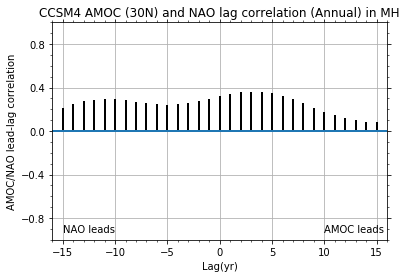

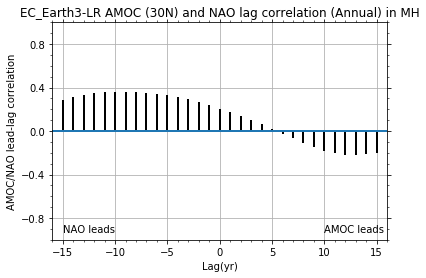

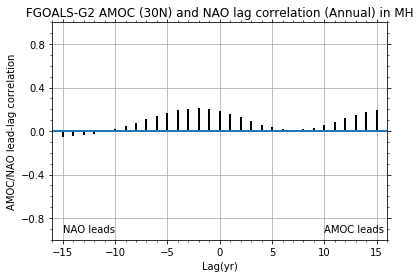

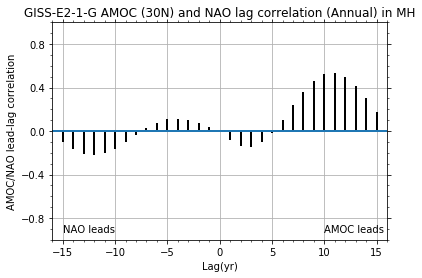

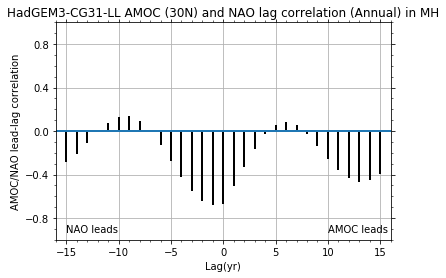

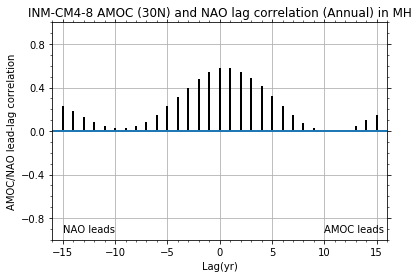

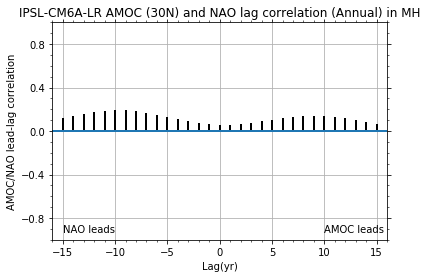

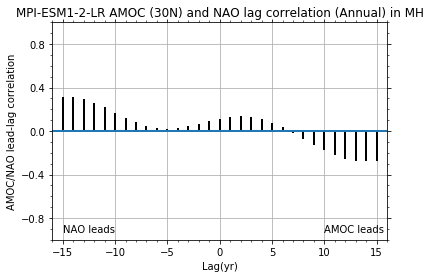

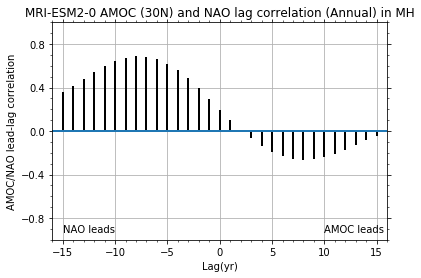

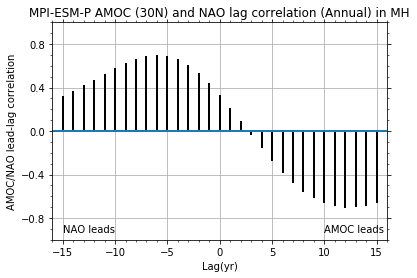

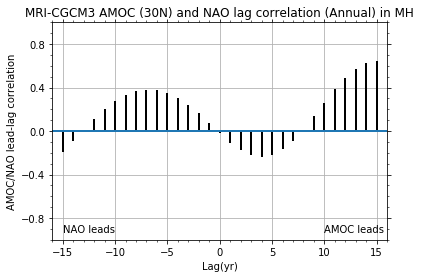

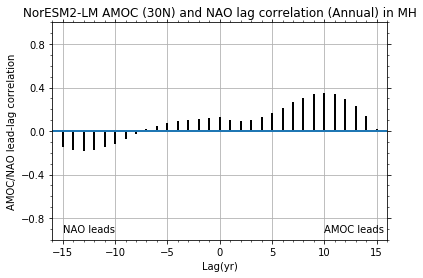

In [51]:
for j in range (0,len(cube_modelname)):
    
    fig=plt.figure()
    ax=fig.add_subplot(111)


    ax.xcorr(globals()[cube_modelname[j]+'_nao_fil'].data, globals()[cube_modelname[j]+'_amoc_fil'].data, detrend=mlab.detrend,usevlines=True, maxlags=15, normed=True, lw=2)
    ax.grid(True)
    ax.text(10,-0.93,'AMOC leads')
    ax.text(-15,-0.93,'NAO leads')
    #ax.axvline(0,color='black',alpha=0.2, linewidth=1)
    #ax.axhline(0,color='black',alpha=0.2, linewidth=1)

    ax.set(xlabel='Lag(yr)', ylabel='AMOC/NAO lead-lag correlation')
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.4))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.tick_params(which='both', direction='out', top=True, right=True, labelsize=10.)
    ax.set_ylim(-1,1)
    ax.set_xlim(-16,16)
    
    ax.set(title='%s AMOC (30N) and NAO lag correlation (Annual) in MH' %(cube_model_name[j]))